In [1]:
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt
tf.enable_eager_execution()

For a long time, when I was approaching HRL I was trying to figure out how it was better then RL.
Obvious (in hindsight) but not so short answer is: it isn't 'better'. That is because of the no-free-lunch theorem.

Simply split the learning complexity between discovering a higher level language.
And the using it.

> The challenge in the single-task case is overcoming the additional cost of discovering the options; this results in a narrow opportu- nity for performance improvements, but a well-defined objective. In the skill transfer case, the key challenge is predicting the usefulness of a particular option to future tasks, given limited data.
Combined. (Konidaris 2019)



$$
E_{f\in F}\Big[E_{x\sim A}[ f(x)]\Big] = E_{x\sim B}[ f(x)] \\
$$

Refs

- [No Free Lunch Theorems for Optimization](https://ti.arc.nasa.gov/m/profile/dhw/papers/78.pdf)
- [A conservation law for generalization performance](http://dml.cs.byu.edu/~cgc/docs/mldm_tools/Reading/LCG.pdf)
- [No More Lunch: Analysis of Sequential Search](https://acff25e7-a-62cb3a1a-s-sites.googlegroups.com/site/boundedtheoretics/CEC04.pdf)
- [A No-Free-Lunch Theorem for Non-Uniform Distributions of Target Functions](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.71.8446&rep=rep1&type=pdf)
- [Simple Explanation of the No-Free-Lunch Theorem and Its Implications](https://link.springer.com/content/pdf/10.1023%2FA%3A1021251113462.pdf)

If you find a search algorithm that performs worse than randomly on some set of optimisation problems, you know it must perform better on the set if all other optimisation problems.
(not quite? as we are not allowed rnd search algols here?)

> Focusing on generalisation rather than accuracy has the effect of normalising differences in traniing set size. The conservation law tells is that overall generalisation performance remains null for every n. As a consequence, performance will increase with increasing n for some regualrities only to the extent that it decreases with n for others.

(can I simulate this empirically. an example!? of decreasing performance?)



- Want to explore a proof where the cost functions have bounded complexity (in the information theorietic sense. they are compressible. Maybe we pick all f such that their information is <= k). Does NFL still hold? (related [paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=870741) and [this one - bounded info](http://mattstreeter.org/Research/mstreeter_gecco_2003.pdf)?)


In [2]:
# search space
n_x = 2
d_x = 3
dims = [tf.range(n_x) for _ in range(d_x)]
X = tf.reshape(tf.stack(tf.meshgrid(*dims)), (n_x**d_x, d_x))
X.shape

TensorShape([Dimension(8), Dimension(3)])

In [3]:
# space of possible cost functions. only 1 dim output
n_y = 2  # 2 possible labels, {0, 1}
n_y ** X.shape[0].value

256

In [4]:
# all possible cost functions
Y = tf.stack(list(itertools.product(*[range(n_y) for _ in range(n_x**d_x)])))
Y.shape

TensorShape([Dimension(256), Dimension(8)])

In [5]:
def make_dataset(X, f, N, batch_size, train=True):
    """
    Args:
        X (array[n, d]): the possible input values.
        f (array[n]): the cost function / labellings
        N (int): the total number of examples to generate
        batch_size (int): the size of the batches
        train (bool): whether to yield training or test data
        
    Yields:
        (tuple): (array[batch_size, d], array[batch_size]). the x, y pairs for supervised training
    """
    # train versus valid set
    minval = 0 if train else int(X.shape[0].value*0.8)
    maxval = int(X.shape[0].value*0.8) if train else X.shape[0]
    
    for _ in range(N):
        idx = tf.random.uniform((batch_size,), minval, maxval, dtype=tf.int32)
        yield tf.gather(X, idx), tf.gather(f, idx)

In [6]:
def update(learner, batch):
    with tf.GradientTape() as tape:
        loss = learner.loss_fn(*batch)

    grads = tape.gradient(loss, learner.net.variables)
    learner.opt.apply_gradients(zip(grads, learner.net.variables))

    return loss

class MLP():
    def __init__(self):

        self.net = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation=tf.nn.selu),
            tf.keras.layers.Dense(n_y)
        ])
        self.opt = tf.train.AdamOptimizer(1e-3)
        
    def __call__(self, x):
        x = tf.cast(x, tf.float32)
        return tf.argmax(self.net(x), axis=1)

    def loss_fn(self, x, t):
        x = tf.cast(x, tf.float32)
        y = self.net(x)
        loss = tf.losses.sparse_softmax_cross_entropy(logits=y, labels=t)
        return tf.reduce_mean(loss)

In [7]:
def eval_learner(X, f, learner):
    """
    Args:
        X (array[]): the search space
        Y (array[]): the cost function
        learner (Learner): a class with __call__ and .update methods
    """
    # train
    losses = []
    for x, t in make_dataset(X, f, 1000, 10):
        L = update(learner, (x, t))
        losses.append(L)

    # eval
    gen_accs = [acc(learner(x), t) for x, t in make_dataset(X, f, 1000, 10, train=False)]

    return losses, tf.reduce_mean(gen_accs)

In [8]:
def acc(y, t):
    return tf.reduce_mean(tf.cast(tf.equal(y, tf.cast(t, tf.int64)), tf.float32))

In [9]:
def free_lunch(Learner, X, Y):
    accs = []
    for i in range(Y.shape[0]):
        print('\r {}'.format(i), end='', flush=True)
        learner = Learner()
        losses, gen_acc = eval_learner(X, Y[i], learner)
        accs.append(gen_acc)
        
    return tf.stack(accs).numpy()

In [10]:
gen_accs = free_lunch(MLP, X, Y)

 255

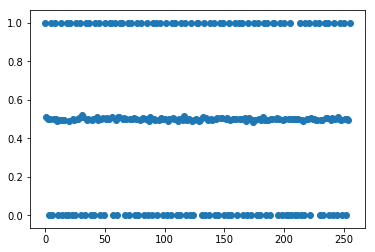

In [12]:
plt.scatter(range(Y.shape[0]), gen_accs)
# plt.plot(range(512), )

In [13]:
tf.reduce_mean(gen_accs - 0.5)

<tf.Tensor: id=37159735, shape=(), dtype=float32, numpy=-0.002035155>

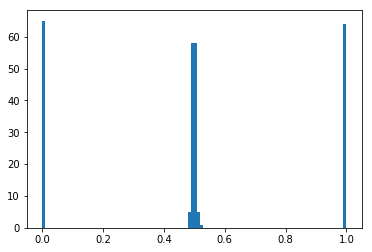

In [15]:
_ = plt.hist(gen_accs, bins=100)

Ahh, i get it now.

> For every cost function where a learner generalises correctly wrt label of $x$, there is another cost function (at least when $y \in \{0, 1\}$) where the learner will generalise incorrectly.


## Matching

> Empirical success in generalisation is always due to problem selection.

We have a matching problem that needs to be solved. Problems to optimisers.
What makes this matching problem hard?

- It can be hard to etimate the problem from calls to the oracle... If we could do so then we could easily optimise it.
- ???

